## Imports

In [24]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import classification_report
import warnings 
import numpy as np
warnings.filterwarnings("ignore")
import seaborn as sns

In [25]:
from math import isnan

In [26]:
import sys
sys.path.append('../src')
from model.proba_model import get_past_meta, predict
from model.evaluation import get_classification_report

## Definitions

In [27]:
# ### Definitions
path_data_dir = '../data/'

list_assets = ["PETR3.SA","PRIO3.SA", "VALE3.SA", "GGBR3.SA", "ABCB4.SA", "ITUB3.SA", "FLRY3.SA", "RADL3.SA"]

relevant_cols = ['Date', 'Close', 'Volume']

In [28]:
list_prev_meta = [i for i in range(1,6)]

## Classification

### Dummy Model

#### Temporal train test split

In [29]:
n_prev_meta = 1


list_results = []
for asset in list_assets:
    
    print(f"""
#################
# asset: {asset}
#################          
          """)
    
    # get train contigency table 
    cont_tbl_train = pd.read_csv(path_data_dir + f"processed/train_contingency_table_price_history_{asset.replace('.', '_')}_meta_range({n_prev_meta})_dataset_ffill.csv", index_col=0, header=[i for i in range(n_prev_meta)])
    
    # create probability table
    df_probas = cont_tbl_train.apply(lambda x: [col/sum(x) for col in x])    
    
    # get test dataset
    test_dataset = pd.read_csv(path_data_dir + f"processed/test_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0)
    
    # get the past meta for all days    
    test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

    # remove the first rows
    test_dataset = test_dataset.iloc[n_prev_meta:]
    
    # get y_test
    y_test = test_dataset.meta
    
    # predict based on probability table
    y_pred = test_dataset.past_meta.astype('int')
    
    # create df with results
    df_results_p = get_classification_report(y_test, y_pred)
    df_results_p['asset'] = asset
    
    print(classification_report(y_test, y_pred))
    
    
    list_results.append(df_results_p)
    
    df_results_p = df_results_p.drop(['weighted avg', 'macro avg', 'accuracy'])
    df_results_p.index = df_results_p.index.astype('int')
    df_results_p = df_results_p.reset_index()
    df_results_p.support = df_results_p.support.astype('int')
    
    df_results_p.drop(['asset'],axis = 1,inplace = True)
    df_results_p.rename(
        {
            'index':'p',
            "precision": 'precision',
            "recall": 'recall',
            "f1-score": 'f1-score',
            "support": "q"
        }
        
        
        ,axis = 1, inplace = True)

    df_results_p.sort_values('p', inplace = True)
    print(df_results_p.to_latex(index=False,float_format="%.2f"))
    
    
    
    
df_results = pd.concat(list_results)


#################
# asset: PETR3.SA
#################          
          
              precision    recall  f1-score   support

          -2       0.58      0.58      0.58        36
          -1       0.75      0.75      0.75       169
           0       0.84      0.84      0.84       458
           1       0.77      0.77      0.77       235
           2       0.63      0.63      0.63        62
           3       0.67      0.67      0.67         3

    accuracy                           0.79       963
   macro avg       0.71      0.71      0.71       963
weighted avg       0.79      0.79      0.79       963

\begin{tabular}{rrrrr}
\toprule
p & precision & recall & f1-score & q \\
\midrule
-2 & 0.58 & 0.58 & 0.58 & 36 \\
-1 & 0.75 & 0.75 & 0.75 & 169 \\
0 & 0.84 & 0.84 & 0.84 & 458 \\
1 & 0.77 & 0.77 & 0.77 & 235 \\
2 & 0.63 & 0.63 & 0.63 & 62 \\
3 & 0.67 & 0.67 & 0.67 & 3 \\
\bottomrule
\end{tabular}


#################
# asset: PRIO3.SA
#################          
          
      

In [30]:
display(df_results.loc['macro avg',['asset', 'f1-score']])

print('f1-macro mean',df_results.loc['macro avg',['f1-score']].mean()[0])

,asset,f1-score
macro avg,PETR3.SA,0.707253
macro avg,PRIO3.SA,0.741171
macro avg,VALE3.SA,0.703038
macro avg,GGBR3.SA,0.658328
macro avg,ABCB4.SA,0.569522
macro avg,ITUB3.SA,0.536868
macro avg,FLRY3.SA,0.701460
macro avg,RADL3.SA,0.611354


f1-macro mean 0.6536243391396331


#### Annual moving train test split

In [31]:
import pandas as pd
from datetime import timedelta, datetime,date
from tqdm import tqdm
from itertools import product
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt

import sys
sys.path.append('../src')
from data.data_split import split_data_by_year
from features.contigency_table import create_contigency_table
from model.proba_model import get_past_meta, predict
from model.evaluation import get_classification_report

In [32]:
df_results = pd.DataFrame({})

for asset in list_assets:    
    
    data = pd.read_csv(path_data_dir + f"processed/price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv")


    data['year'] = pd.to_datetime(data.Date).dt.year

    # create tuples (years train, years test)
    years = list(data.year.unique())
    train_test_years = [([years[i]], [years[i] + 1]) for i in range(len(years) - 1)]
    train_test_years
    
    for years_train, years_test in train_test_years:
    
        train_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_train)]
        test_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_test)]
                
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset.past_meta.astype('int')
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        df_results_p['years_train'] = str(years_train)
        df_results_p['years_test'] = str(years_test)
        
        df_results = pd.concat([df_results, df_results_p])

In [33]:
domains_list = [["PETR3.SA","PRIO3.SA"], ["VALE3.SA", "GGBR3.SA"], ["ABCB4.SA", "ITUB3.SA"], ["FLRY3.SA", "RADL3.SA"]]

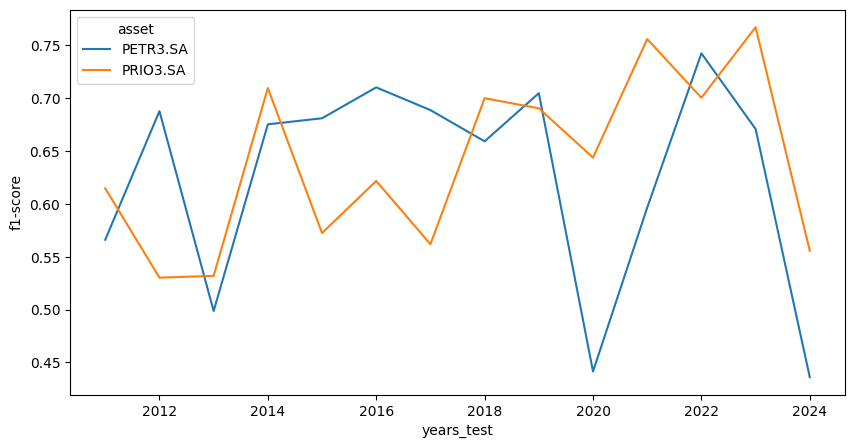

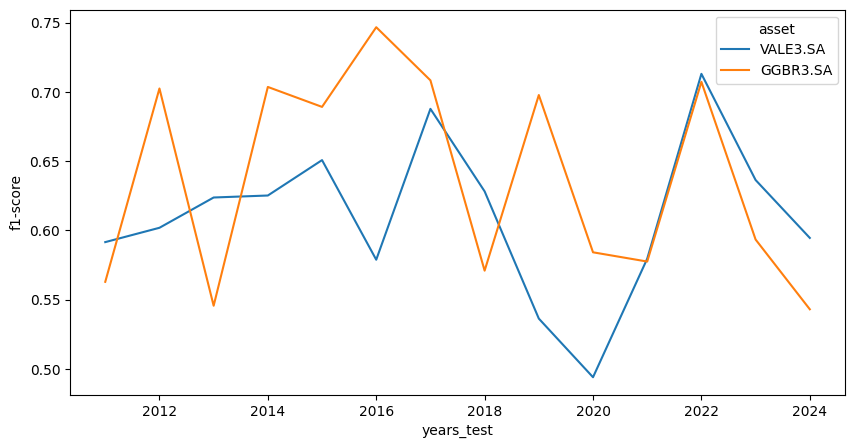

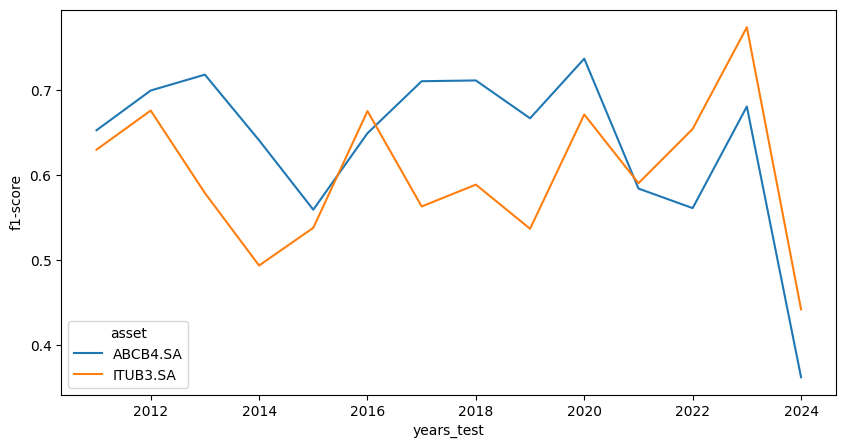

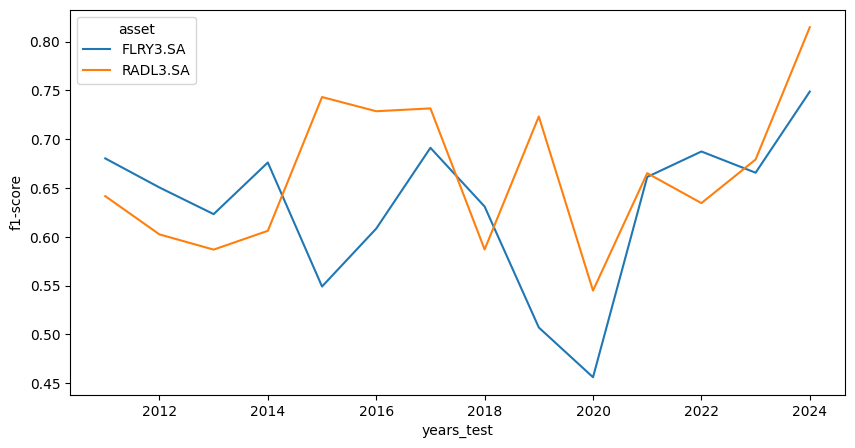

In [34]:
df_results.years_train = df_results.years_train.apply(lambda x: int(eval(x)[0]))
df_results.years_test = df_results.years_test.apply(lambda x: int(eval(x)[0]))
df_results_metric = df_results.loc['macro avg', :]


for asset_domain_list in domains_list:

    fig, ax = plt.subplots(figsize=(10, 5))


    sns.lineplot(data=df_results_metric[df_results_metric.asset.isin(asset_domain_list)] , x="years_test", y='f1-score', hue="asset", ax = ax)

    plt.show()

In [35]:
print(df_results.loc['macro avg', ['n_prev_meta', 'f1-score']].groupby('n_prev_meta').mean('f1-score').to_latex())

\begin{tabular}{lr}
\toprule
 & f1-score \\
n_prev_meta &  \\
\midrule
1 & 0.630889 \\
\bottomrule
\end{tabular}



### Bayesian dependent model

#### Temporal train test split

In [13]:
df_results = pd.DataFrame({})

for n_prev_meta in tqdm(list_prev_meta):

    for asset in list_assets:
        
        # get train contigency table 
        cont_tbl_train = pd.read_csv(path_data_dir + f"processed/train_contingency_table_price_history_{asset.replace('.', '_')}_meta_range({n_prev_meta})_dataset_ffill.csv", index_col=0, header=[i for i in range(n_prev_meta)])
        
        # create probability table
        df_probas = cont_tbl_train.apply(lambda x: [col/sum(x) for col in x])    
        
        # get test dataset
        test_dataset = pd.read_csv(path_data_dir + f"processed/test_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0)
        
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset.past_meta.apply(lambda x: predict(x, df_probas))
        
        print(f'Number of nan {asset}: ',y_pred.isna().sum()/len(y_pred), '%')
        
        # when the value is nan, repeat the last predict
        y_pred.ffill(inplace=True)
        #y_pred.fillna(0, inplace = True)
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        
        df_results = pd.concat([df_results, df_results_p])

  0%|          | 0/5 [00:00<?, ?it/s]

Number of nan PETR3.SA:  0.0 %
Number of nan PRIO3.SA:  0.0 %
Number of nan VALE3.SA:  0.0 %
Number of nan GGBR3.SA:  0.0 %
Number of nan ABCB4.SA:  0.0 %
Number of nan ITUB3.SA:  0.0 %


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

Number of nan FLRY3.SA:  0.0 %
Number of nan RADL3.SA:  0.0 %
Number of nan PETR3.SA:  0.0 %
Number of nan PRIO3.SA:  0.0010395010395010396 %
Number of nan VALE3.SA:  0.0 %
Number of nan GGBR3.SA:  0.0 %
Number of nan ABCB4.SA:  0.0 %
Number of nan ITUB3.SA:  0.0010395010395010396 %


 40%|████      | 2/5 [00:02<00:03,  1.21s/it]

Number of nan FLRY3.SA:  0.0 %
Number of nan RADL3.SA:  0.0010395010395010396 %
Number of nan PETR3.SA:  0.005202913631633715 %
Number of nan PRIO3.SA:  0.005202913631633715 %
Number of nan VALE3.SA:  0.005202913631633715 %
Number of nan GGBR3.SA:  0.005202913631633715 %
Number of nan ABCB4.SA:  0.003121748178980229 %
Number of nan ITUB3.SA:  0.004162330905306972 %
Number of nan FLRY3.SA:  0.0 %
Number of nan RADL3.SA:  0.004162330905306972 %


 60%|██████    | 3/5 [00:03<00:02,  1.38s/it]

Number of nan PETR3.SA:  0.013541666666666667 %
Number of nan PRIO3.SA:  0.014583333333333334 %
Number of nan VALE3.SA:  0.022916666666666665 %
Number of nan GGBR3.SA:  0.01875 %
Number of nan ABCB4.SA:  0.01875 %
Number of nan ITUB3.SA:  0.0125 %
Number of nan FLRY3.SA:  0.003125 %
Number of nan RADL3.SA:  0.0125 %


 80%|████████  | 4/5 [00:05<00:01,  1.52s/it]

Number of nan PETR3.SA:  0.03441084462982273 %
Number of nan PRIO3.SA:  0.029197080291970802 %
Number of nan VALE3.SA:  0.043795620437956206 %
Number of nan GGBR3.SA:  0.03962460896767466 %
Number of nan ABCB4.SA:  0.04483837330552659 %
Number of nan ITUB3.SA:  0.03023983315954119 %
Number of nan FLRY3.SA:  0.017726798748696558 %


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]

Number of nan RADL3.SA:  0.029197080291970802 %


<Axes: xlabel='n_prev_meta', ylabel='f1-score'>

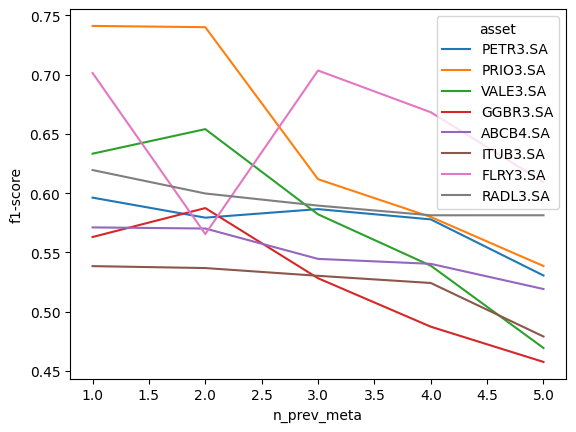

In [14]:
df_metrics = df_results.loc['macro avg', :]
sns.lineplot(data=df_metrics, x="n_prev_meta", y="f1-score", hue="asset")

In [15]:
display()

print('f1-macro mean',df_results.loc['macro avg',['f1-score']].mean()[0])

f1-macro mean 0.5789780690796602


In [16]:
display(df_results.loc['macro avg',['asset', 'n_prev_meta', 'f1-score']].groupby(['asset', 'n_prev_meta']).mean())

display(df_results.loc['macro avg',['n_prev_meta', 'f1-score']].groupby(['n_prev_meta']).mean())

f1-score
asset    n_prev_meta          
ABCB4.SA 1            0.571177
         2            0.570229
         3            0.544606
         4            0.540433
         5            0.519174
FLRY3.SA 1            0.701460
         2            0.565557
         3            0.703552
         4            0.668341
         5            0.609427
GGBR3.SA 1            0.563061
         2            0.587471
         3            0.528278
         4            0.487401
         5            0.457669
ITUB3.SA 1            0.538494
         2            0.536868
         3            0.530324
         4            0.524272
         5            0.479114
PETR3.SA 1            0.596290
         2            0.579391
         3            0.586601
         4            0.577937
         5            0.530598
PRIO3.SA 1            0.741171
         2            0.740112
         3            0.611842
         4            0.579994
         5            0.538597
RADL3.SA 1            0.619564
         2            0.599791
         3            0.589557
         4            0.581401
         5            0.581394
VALE3.SA 1            0.633368
         2            0.654084
         3            0.582202
         4            0.538885
         5            0.469438

,f1-score
n_prev_meta,
1,0.620573
2,0.604188
3,0.584620
4,0.562333
5,0.523176


In [17]:
mean_score = df_results.loc['macro avg', :].groupby('n_prev_meta').mean('f1-score')
print('Mean score:')
display(mean_score)

best_prev_meta = mean_score['f1-score'].idxmax()
print('best prev meta', best_prev_meta)

Mean score:


,precision,recall,f1-score,support
n_prev_meta,,,,
1,0.618744,0.622513,0.620573,963.0
2,0.616417,0.596607,0.604188,962.0
3,0.601036,0.573988,0.584620,961.0
4,0.579090,0.551723,0.562333,960.0
5,0.559123,0.505383,0.523176,959.0


best prev meta 1


In [18]:
for asset in list_assets:
    
    
    print(f"""
#################
# asset: {asset}
#################          
          """)
    
    df_results_p = df_results[
        (df_results.n_prev_meta == best_prev_meta) & 
        (df_results.asset == asset)
        ]
        
    df_results_p = df_results_p.drop(['weighted avg', 'macro avg', 'accuracy'])
    df_results_p.index = df_results_p.index.astype('int')
    df_results_p = df_results_p.reset_index()
    df_results_p.support = df_results_p.support.astype('int')

    df_results_p.drop(['asset', 'n_prev_meta'],axis = 1,inplace = True)
    df_results_p.rename(
        {
            'index':'p',
            "precision": 'precision',
            "recall": 'recall',
            "f1-score": 'f1-score',
            "support": "q"
        }
        
        
        ,axis = 1, inplace = True)

    df_results_p.sort_values('p', inplace = True)
    print(df_results_p.to_latex(index=False,float_format="%.2f"))
    
    
    


#################
# asset: PETR3.SA
#################          
          
\begin{tabular}{rrrrr}
\toprule
p & precision & recall & f1-score & q \\
\midrule
-2 & 0.58 & 0.58 & 0.58 & 36 \\
-1 & 0.75 & 0.75 & 0.75 & 169 \\
0 & 0.84 & 0.84 & 0.84 & 458 \\
1 & 0.77 & 0.77 & 0.77 & 235 \\
2 & 0.62 & 0.65 & 0.63 & 62 \\
3 & 0.00 & 0.00 & 0.00 & 3 \\
\bottomrule
\end{tabular}


#################
# asset: PRIO3.SA
#################          
          
\begin{tabular}{rrrrr}
\toprule
p & precision & recall & f1-score & q \\
\midrule
-2 & 0.70 & 0.70 & 0.70 & 37 \\
-1 & 0.72 & 0.72 & 0.72 & 147 \\
0 & 0.83 & 0.83 & 0.83 & 454 \\
1 & 0.76 & 0.76 & 0.76 & 249 \\
2 & 0.68 & 0.68 & 0.68 & 76 \\
\bottomrule
\end{tabular}


#################
# asset: VALE3.SA
#################          
          
\begin{tabular}{rrrrr}
\toprule
p & precision & recall & f1-score & q \\
\midrule
-3 & 0.67 & 0.67 & 0.67 & 6 \\
-2 & 0.71 & 0.71 & 0.71 & 75 \\
-1 & 0.75 & 0.75 & 0.75 & 224 \\
0 & 0.84 & 0.84 & 0.84 & 4

In [19]:
df_results_p

,p,precision,recall,f1-score,q
3,-2,0.750000,0.750000,0.750000,48
2,-1,0.757225,0.757225,0.757225,173
0,0,0.810155,0.811947,0.811050,452
1,1,0.779923,0.776923,0.778420,260
4,2,0.600000,0.642857,0.620690,28
5,3,0.000000,0.000000,0.000000,2


#### Annual moving train test split

In [20]:
df_results = pd.DataFrame({})

for n_prev_meta, asset in tqdm(product(list_prev_meta, list_assets), total = len(list_prev_meta)*len(list_assets)):    
    
    data = pd.read_csv(path_data_dir + f"processed/price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv")


    data['year'] = pd.to_datetime(data.Date).dt.year

    # create tuples (years train, years test)
    years = list(data.year.unique())
    train_test_years = [([years[i]], [years[i] + 1]) for i in range(len(years) - 1)]
    train_test_years = train_test_years[1:-1]
    
    for years_train, years_test in train_test_years:
    
        train_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_train)]
        test_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_test)]
        
        train_ct = create_contigency_table(
            data = train_dataset,
            n_prev_meta = n_prev_meta,
            progress_bar=False,
            as_probability= True
        )
        
        train_ct.to_csv('temp.csv')
        train_ct = pd.read_csv('temp.csv',index_col=0, header=[i for i in range(n_prev_meta)])
        
        
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)
        
        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
                
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset.past_meta.apply(lambda x: predict(x, train_ct))
    
        # when the value is nan, repeat the value of the last day
        if y_pred.isna().sum() > 0:
            
            if n_prev_meta == 1:
                y_pred = [y_pred[i] if not isnan(y_pred[i]) else int(test_dataset.past_meta.loc[i]) for i in y_pred.index]
                
            else:y_pred = [y_pred[i] if not isnan(y_pred[i]) else int(test_dataset.past_meta.loc[i][0]) for i in y_pred.index]
            
             
        
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        df_results_p['years_train'] = str(years_train)
        df_results_p['years_test'] = str(years_test)
        
        df_results = pd.concat([df_results, df_results_p])

100%|██████████| 40/40 [03:24<00:00,  5.10s/it]


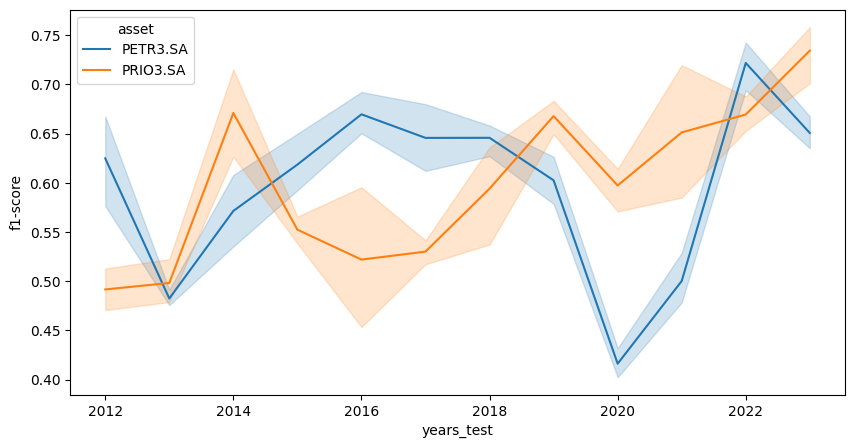

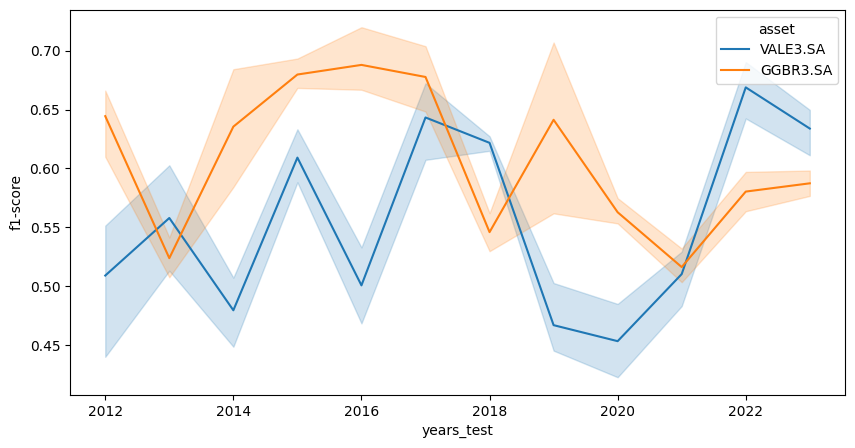

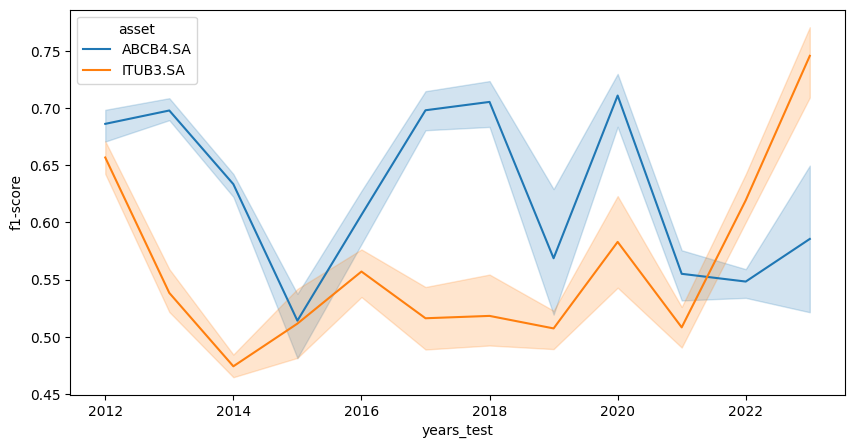

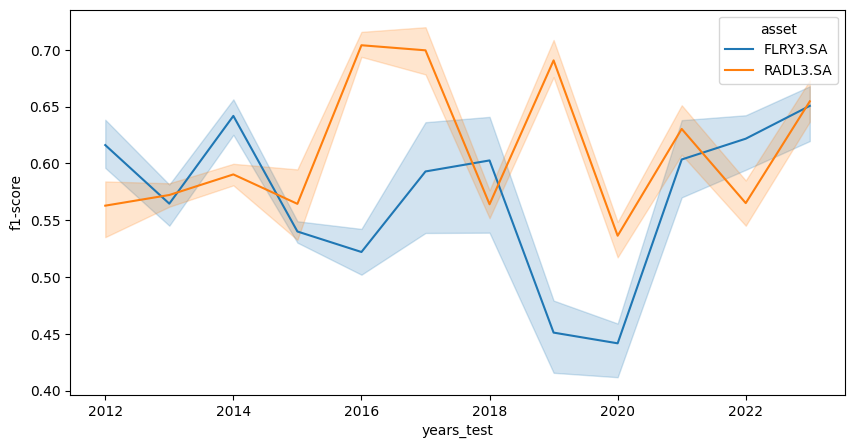

In [21]:
df_results.years_train = df_results.years_train.apply(lambda x: int(eval(x)[0]))
df_results.years_test = df_results.years_test.apply(lambda x: int(eval(x)[0]))
df_results_metric = df_results.loc['macro avg', :]


for asset_domain_list in domains_list:

    fig, ax = plt.subplots(figsize=(10, 5))


    sns.lineplot(data=df_results_metric[df_results_metric.asset.isin(asset_domain_list)] , x="years_test", y='f1-score', hue="asset", ax = ax)

    plt.show()

In [22]:
df_results.loc['macro avg', ['n_prev_meta', 'f1-score']].groupby('n_prev_meta').mean('f1-score')

,f1-score
n_prev_meta,
1,0.597081
2,0.600903
3,0.590262
4,0.584450
5,0.580255


In [23]:
print(df_results.loc['macro avg', ['n_prev_meta', 'f1-score']].groupby('n_prev_meta').mean('f1-score').to_latex())

\begin{tabular}{lr}
\toprule
 & f1-score \\
n_prev_meta &  \\
\midrule
1 & 0.597081 \\
2 & 0.600903 \\
3 & 0.590262 \\
4 & 0.584450 \\
5 & 0.580255 \\
\bottomrule
\end{tabular}



### Bayesian dependent model

#### Temporal train test split

In [32]:
def get_probability(past_meta_list, possible_metas, asset):
    
    dict_probas = {}
    
    for p_meta in possible_metas:
        
        list_probas_meta = []
        
 
        for i, past_meta in enumerate(past_meta_list):
            
            meta_idx = i + 1
            
            path_data = path_data_dir + f"processed/train_contingency_table_ind_price_history_{asset.replace('.', '_')}_meta_-{meta_idx}_dataset_ffill.csv"
        
            cont_tbl_train = pd.read_csv(path_data, index_col = 0)
            
            df_probas = cont_tbl_train.apply(lambda x: [col/sum(x) for col in x])   
            
            proba = df_probas.loc[p_meta, past_meta]
            
            list_probas_meta.append(proba)
            
        dict_probas.update({p_meta: {'probas':list_probas_meta, "prod": np.product(list_probas_meta)}})
        
    return dict_probas
        
        

In [33]:
# remove n_prev = 1, is equal to the dependent
list_prev_meta_ind = list_prev_meta.copy()
list_prev_meta_ind.remove(1)

In [ ]:
df_results = pd.DataFrame({})




for n_prev_meta in list_prev_meta_ind:

    for asset in list_assets:
        
        print(f"""
######################################
# asset: {asset} | meta: {n_prev_meta}
######################################""")
        
        # get train dataset
        train_dataset = pd.read_csv(path_data_dir + f"processed/train_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0).reset_index(drop=True)
        # get test dataset
        test_dataset = pd.read_csv(path_data_dir + f"processed/test_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0).reset_index(drop=True)
        
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)
        
        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
                
        possible_metas = train_dataset.meta.unique().tolist()
                
        test_dataset['dict_probas'] = test_dataset.past_meta.progress_apply(lambda x: get_probability(list(x), possible_metas, asset))
        
        test_dataset['most_likely_meta'] = test_dataset.dict_probas.progress_apply(lambda row: max(row, key=lambda x: row[x]['prod']))
        
        # create df with results
        df_results_p = get_classification_report(test_dataset['meta'], test_dataset['most_likely_meta'])
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        
        df_results = pd.concat([df_results, df_results_p])
        
        print(classification_report(test_dataset['meta'], test_dataset['most_likely_meta']))        
        
        df_results_p = df_results_p.drop(['weighted avg', 'macro avg', 'accuracy'])
        df_results_p.index = df_results_p.index.astype('int')
        df_results_p = df_results_p.reset_index()
        df_results_p.support = df_results_p.support.astype('int')
        
        df_results_p.drop(['asset'],axis = 1,inplace = True)
        df_results_p.rename(
            {
                'index':'p',
                "precision": 'precision',
                "recall": 'recall',
                "f1-score": 'f1-score',
                "support": "q"
            }
            
            
            ,axis = 1, inplace = True)

        df_results_p.sort_values('p', inplace = True)
        print(df_results_p.to_latex(index=False,float_format="%.2f"))

In [ ]:
df_metrics = df_results.loc['macro avg', :]
sns.lineplot(data=df_metrics, x="n_prev_meta", y="f1-score", hue="asset")

In [ ]:
mean_score = df_results.groupby('n_prev_meta').mean('f1-score')
print('Mean score:')
display(mean_score)

best_prev_meta = mean_score['f1-score'].idxmax()
print('best prev meta', best_prev_meta)

In [ ]:
for asset in list_assets:
    
    
    print(f"""
#################
# asset: {asset}
#################          
          """)
    
    df_results_p = df_results[
        (df_results.n_prev_meta == best_prev_meta) & 
        (df_results.asset == asset)
        ]
        
    df_results_p = df_results_p.drop(['weighted avg', 'macro avg', 'accuracy'])
    df_results_p.index = df_results_p.index.astype('int')
    df_results_p = df_results_p.reset_index()
    df_results_p.support = df_results_p.support.astype('int')

    df_results_p.drop(['asset', 'n_prev_meta'],axis = 1,inplace = True)
    df_results_p.rename(
        {
            'index':'p',
            "precision": 'precision',
            "recall": 'recall',
            "f1-score": 'f1-score',
            "support": "q"
        }
        
        
        ,axis = 1, inplace = True)

    df_results_p.sort_values('p', inplace = True)
    print(df_results_p.to_latex(index=False,float_format="%.2f"))

#### Annual moving train test split

In [34]:
df_results = pd.DataFrame({})

for n_prev_meta, asset in tqdm(product(list_prev_meta_ind, list_assets), total = len(list_prev_meta_ind)*len(list_assets)):    
    
    data = pd.read_csv(path_data_dir + f"processed/price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv")

    data['year'] = pd.to_datetime(data.Date).dt.year

    # create tuples (years train, years test)
    years = list(data.year.unique())
    train_test_years = [([years[i]], [years[i] + 1]) for i in range(len(years) - 1)]
    train_test_years = train_test_years[1:-1]
    
    for years_train, years_test in train_test_years:
    
        train_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_train)]
        test_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_test)]
                
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)
        
        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        possible_metas = train_dataset.meta.unique().tolist()
        test_dataset['dict_probas'] = test_dataset.past_meta.apply(lambda x: get_probability(list(x), possible_metas, asset))
        test_dataset['most_likely_meta'] = test_dataset.dict_probas.apply(lambda row: max(row, key=lambda x: row[x]['prod']))
                
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset['most_likely_meta']
    
        # when the value is nan, repeat the value of the last day
        if y_pred.isna().sum() > 0:
            
            if n_prev_meta == 1:
                y_pred = [y_pred[i] if not isnan(y_pred[i]) else int(test_dataset.past_meta.loc[i]) for i in y_pred.index]
                
            else:y_pred = [y_pred[i] if not isnan(y_pred[i]) else int(test_dataset.past_meta.loc[i][0]) for i in y_pred.index]
            
             
        
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        df_results_p['years_train'] = str(years_train)
        df_results_p['years_test'] = str(years_test)
        
        df_results = pd.concat([df_results, df_results_p])

100%|██████████| 32/32 [1:04:14<00:00, 120.44s/it]


In [39]:
df_results.loc['macro avg', ['n_prev_meta', 'f1-score']].groupby('n_prev_meta').mean('f1-score')

,f1-score
n_prev_meta,
2,0.549738
3,0.443506
4,0.389405
5,0.368740


In [41]:
print(df_results.loc['macro avg', ['n_prev_meta', 'f1-score']].groupby('n_prev_meta').mean('f1-score').to_latex())

\begin{tabular}{lr}
\toprule
 & f1-score \\
n_prev_meta &  \\
\midrule
2 & 0.549738 \\
3 & 0.443506 \\
4 & 0.389405 \\
5 & 0.368740 \\
\bottomrule
\end{tabular}



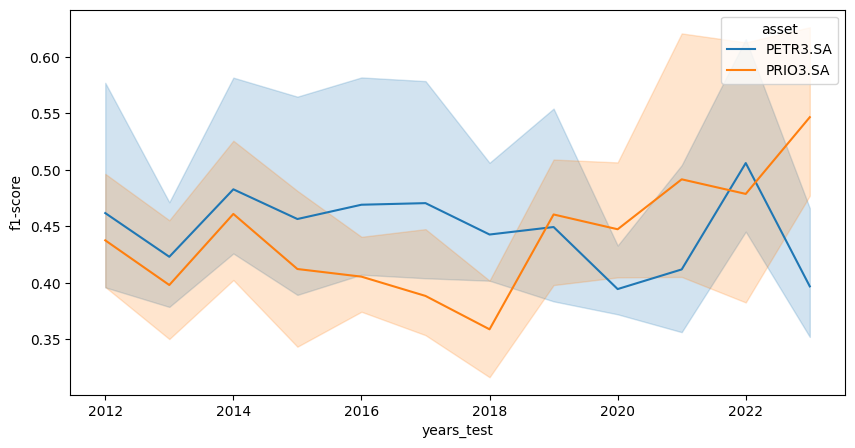

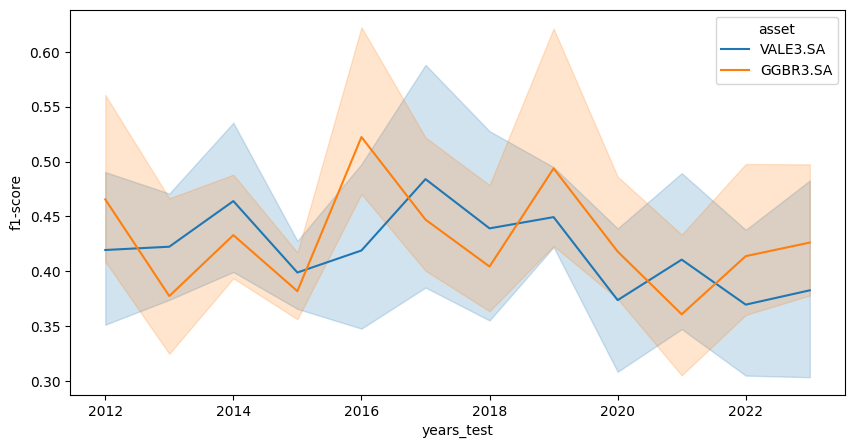

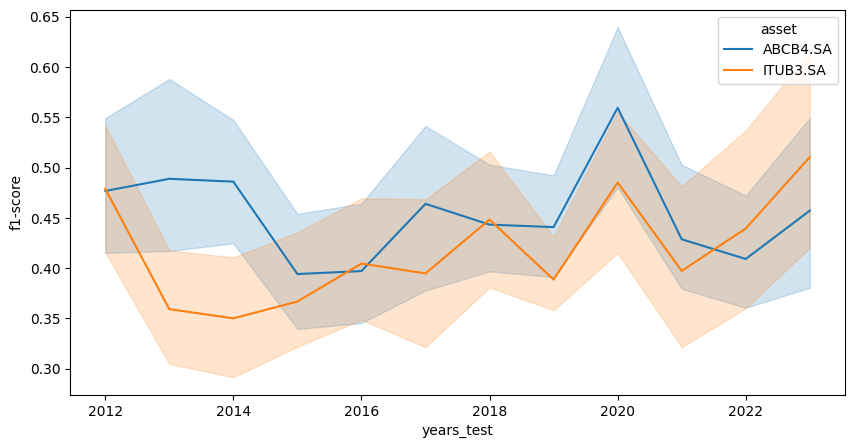

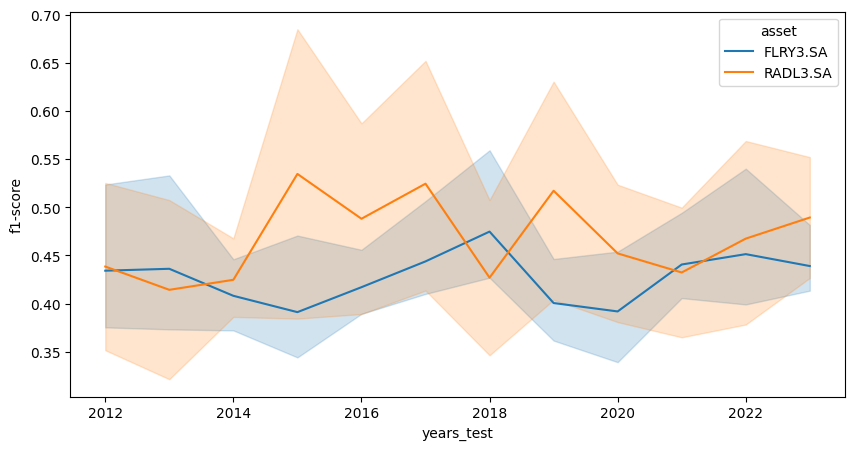

In [35]:
df_results.years_train = df_results.years_train.apply(lambda x: int(eval(x)[0]))
df_results.years_test = df_results.years_test.apply(lambda x: int(eval(x)[0]))
df_results_metric = df_results.loc['macro avg', :]


for asset_domain_list in domains_list:

    fig, ax = plt.subplots(figsize=(10, 5))


    sns.lineplot(data=df_results_metric[df_results_metric.asset.isin(asset_domain_list)] , x="years_test", y='f1-score', hue="asset", ax = ax)

    plt.show()